In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
print("Numpy Version:", np.__version__)
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print("Pandas Version:", pd.__version__)
import sklearn as sk # sklearn for ML modelling
print("Sklearn Version:", pd.__version__)
import matplotlib.pyplot as plt
import matplotlib
print("Matplotlib Version:", matplotlib.__version__)
import seaborn as sns
print("Seaborn Version:", sns.__version__)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Sklearn Version: 2.2.3
Matplotlib Version: 3.7.5
Seaborn Version: 0.12.2
/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# PROJECT PIPELINE
**PIPELINE**
- Data Importation: import data and split into opportune groups (numerical, categorical, et cetera...)
- EDA: Visualize data with Matplotlib to gain insights
- Data preprocessing: Preprocess data, many ways to do. Especially for missing values.
- Modelling: Use many models, test performance by using RKF.
- Submit!

# DATA INTEGRATION

In [2]:
path = r"/kaggle/input/spaceship-titanic/"

# Import data
tc_train = pd.read_csv(path+"train.csv")
tc_test = pd.read_csv(path+"test.csv")

# Swet PassengerId as index
tc_train = tc_train.set_index(tc_train["PassengerId"]).drop(columns="PassengerId")
tc_test = tc_test.set_index(tc_test["PassengerId"]).drop(columns="PassengerId")

# Split train and test into categorical and numerical
tc_train_n = tc_train.select_dtypes(exclude="O")
tc_train_o = tc_train.select_dtypes(include="O")

tc_test_n = tc_test.select_dtypes(exclude="O")
tc_test_o = tc_test.select_dtypes(include="O")

In [3]:
tc_train.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


In [4]:
tc_train_n.head(3)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,
0001_01,39.0,0.0,0.0,0.0,0.0,0.0,False
0002_01,24.0,109.0,9.0,25.0,549.0,44.0,True
0003_01,58.0,43.0,3576.0,0.0,6715.0,49.0,False


In [5]:
tc_train_o.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
PassengerId,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent


# EDA (EXPLORATORY DATA ANALYSIS)
Reminder:
- `tc_train` for train data
- `tc_test` for test data
- any of them appended with `_n` or `_o` is to select either numerical or categorical variables 

In [6]:
# See train data info
tc_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Cabin         8494 non-null   object 
 3   Destination   8511 non-null   object 
 4   Age           8514 non-null   float64
 5   VIP           8490 non-null   object 
 6   RoomService   8512 non-null   float64
 7   FoodCourt     8510 non-null   float64
 8   ShoppingMall  8485 non-null   float64
 9   Spa           8510 non-null   float64
 10  VRDeck        8505 non-null   float64
 11  Name          8493 non-null   object 
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 891.4+ KB


In [7]:
# Calculate percentage of missing rows for each data column
t = tc_train.shape[0]
for column in tc_train.columns:
    print(f"{column} has {((tc_train[column].isna().sum())/(t)).round(4)*100}% of missing data")

HomePlanet has 2.31% of missing data
CryoSleep has 2.5% of missing data
Cabin has 2.29% of missing data
Destination has 2.09% of missing data
Age has 2.06% of missing data
VIP has 2.34% of missing data
RoomService has 2.08% of missing data
FoodCourt has 2.11% of missing data
ShoppingMall has 2.39% of missing data
Spa has 2.11% of missing data
VRDeck has 2.16% of missing data
Name has 2.3% of missing data
Transported has 0.0% of missing data


<Axes: >

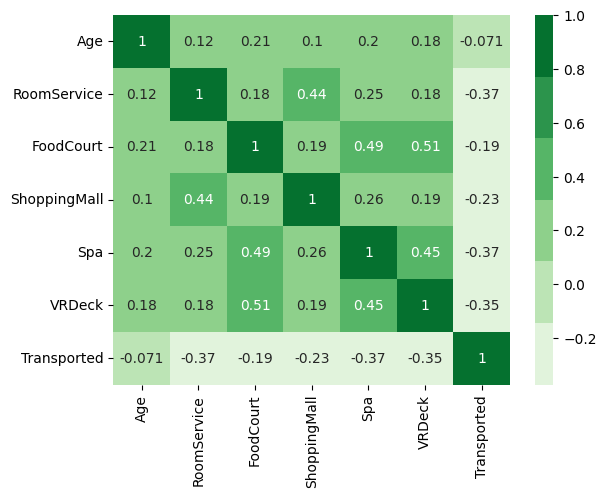

In [8]:
# Visualize correlation between data
fig, axes = plt.subplots(1, 1)
map_c = sns.color_palette("Greens")
sns.heatmap(tc_train_n.corr(method="spearman"), annot=True, ax=axes, cmap=map_c)


In [9]:
# Get statistical Info
tc_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [10]:
tc_train.describe(include='O')

,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8492,8476,8494,8511,8490,8493
unique,3,2,6560,3,2,8473
top,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,4602,5439,8,5915,8291,2


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):
/opt/conda/lib/pyth

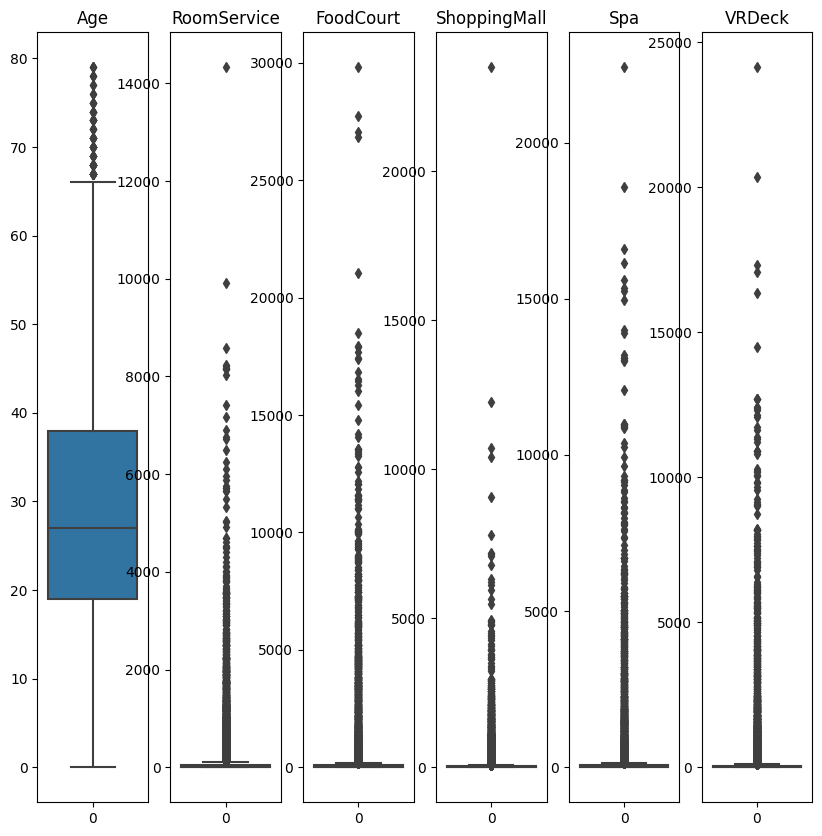

In [11]:
# Analyze boxplots
x = tc_train_n.drop(columns="Transported", inplace=False)
num_cols = x.shape[1]
fig, axes = plt.subplots(1, num_cols, figsize=(10, 10))

for col, i in zip(x.columns.tolist(), range(0, num_cols)):
    sns.boxplot(data=x[col], ax=axes[i])
    axes[i].set_title(col)

# Feature Engineering
Data has a lot of outliers.

# MODELLING